**T1**

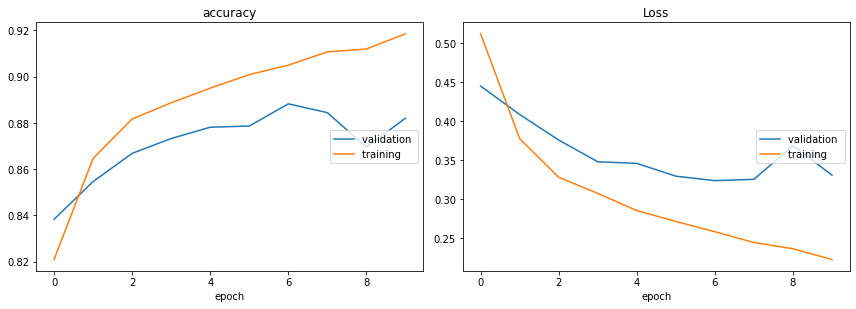

accuracy
	validation       	 (min:    0.838, max:    0.888, cur:    0.882)
	training         	 (min:    0.821, max:    0.918, cur:    0.918)
Loss
	validation       	 (min:    0.324, max:    0.445, cur:    0.331)
	training         	 (min:    0.223, max:    0.512, cur:    0.223)
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


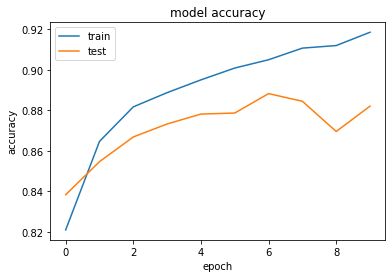

Scores:  [0.3310055620312691, 0.8820000290870667]
Erro modelo MLP: 11.80%


In [3]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback
from tensorflow.keras.datasets import fashion_mnist

def _get_available_gpus():  

    if tfback._LOCAL_DEVICES is None:  
        devices = tf.config.list_logical_devices()  
        tfback._LOCAL_DEVICES = [x.name for x in devices]  
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

# fixar random seed para se puder reproduzir os resultados
seed = 9
np.random.seed(seed)

# Etapa 1 - preparar o dataset
'''
fazer o download do MNIST dataset com imagens de digitos escritos à mão para fazer a
sua classificação (já pré-preparados)
dataset: https://s3.amazonaws.com/img-datasets/mnist.npz
O ficheiro já tem tudo separado nos ficheiros {x_test.npy, x_train.npy, y_test.npy,
y_train.npy}
Os atributos de entrada estão com matrizes 3D(imagem, largura,altura) e os atributos de
saída é uma lista com o número correspondente
'''
def load_mnist_dataset(path='mnist.npz'):
    path = get_file(path, origin='https://s3.amazonaws.com/img-datasets/mnist.npz')
    f = np.load(path)
    x_train = f['x_train']
    y_train = f['y_train']
    x_test = f['x_test']
    y_test = f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)

# Visualizar 6 imagens do mnist numa escala de cinzentos
def visualize_mnist():
    (X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    plt.subplot(321)
    plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
    plt.subplot(322)
    plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
    plt.subplot(323)
    plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
    plt.subplot(324)
    plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
    plt.subplot(325)
    plt.imshow(X_train[4], cmap=plt.get_cmap('gray'))
    plt.subplot(326)
    plt.imshow(X_train[5], cmap=plt.get_cmap('gray'))
    plt.show()
    
# Etapa 2 - Definir a topologia da rede (arquitectura do modelo) e compilar (multilayer_perceptrons)
'''
cria-se um modelo sequencial e vai-se acrescentando camadas (layers)
vamos criar uma rede simples com uma camada escondida
Dense class significa que teremos um modelo fully connected
 o primeiro parametro estabelece o número de neuronios na camada (num_pixeis na primeira)
 input_dim=num_pixeis indica o número de entradas do nosso dataset (num_pixeis atributos neste
caso)
 kernel_initializer indica o metodo de inicialização dos pesos das ligações
 'nomal' sigifica com small number generator from Gaussion distribution
 "activation" indica a activation fuction
 'relu' rectifier linear unit activation function com range entre 0 e infinito
 'softmax' foi utilizada para garantir uma percentagem (valor entre 0 e 1) a totalizar entre
todas as saidas o valor de 1
Compile - loss - funcão a ser utilizada no calculo da diferença entre o pretendido e o obtido
vamos utilizar logaritmic loss para classificação binária: 'categorical_crossentropy'
o algoritmo de gradient descent será o “adam” pois é eficiente
a métrica a ser utilizada no report durante o treino será 'accuracy' pois trata-se de um problema de
classificacao
'''
def create_compile_model_mlp(num_pixels, num_classes):
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 

#util para visualizar a topologia da rede num ficheiro em pdf ou png
def print_model(model,fich):
    from keras.utils import plot_model
    plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)
    
#utils para visulaização do historial de aprendizagem
def print_history_accuracy(history):
    print(history.history.keys())
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def print_history_loss(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def mnist_fashion_utilizando_mlp():
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    # transformar a matriz 28*28 das imagens num vector com 784 atributos para cada imagem (porque é multilayer-perceptron)
    num_pixels= X_train.shape[1] * X_train.shape[2]
    X_train= X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
    X_test= X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
    # normalizar os valores dos pixeis de 0-255 para 0-1
    X_train= X_train/ 255
    X_test= X_test/ 255
    # transformar o label que é um inteiro em categorias binárias, o valor passa a ser o correspondente à posição
    # o 5 passa a ser a lista [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    y_train= np_utils.to_categorical(y_train)
    y_test= np_utils.to_categorical(y_test)
    num_classes= y_test.shape[1]
    # definir a topologia da rede e compilar 
    model = create_compile_model_mlp(num_pixels, num_classes)
    print_model(model,"modelT4.1.png")
    # treinar a rede
    plotlosses = PlotLossesKeras()
    history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2
                      ,callbacks=[plotlosses])
    print_history_accuracy(history)
    # Avaliação final com os casos de teste
    scores = model.evaluate(X_test, y_test, verbose=0)
    print('Scores: ', scores)
    print("Erro modelo MLP: %.2f%%"% (100-scores[1]*100))

if __name__ == '__main__':
 #visualize_mnist()
 mnist_fashion_utilizando_mlp()

**T2**

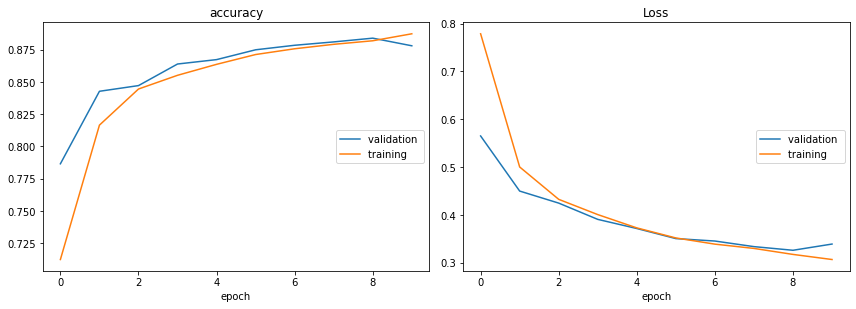

accuracy
	validation       	 (min:    0.787, max:    0.888, cur:    0.878)
	training         	 (min:    0.713, max:    0.918, cur:    0.887)
Loss
	validation       	 (min:    0.324, max:    0.565, cur:    0.339)
	training         	 (min:    0.223, max:    0.779, cur:    0.307)
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


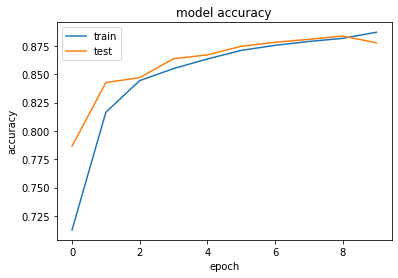

Scores:  [0.3389237044095993, 0.8779000043869019]
Erro modelo MLP: 12.21%


In [4]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pyplot as plt
import  tensorflow as tf
import keras.backend.tensorflow_backend as tfback
from keras.utils.data_utils import get_file
from tensorflow.keras.datasets import fashion_mnist

def _get_available_gpus():  

    if tfback._LOCAL_DEVICES is None:  
        devices = tf.config.list_logical_devices()  
        tfback._LOCAL_DEVICES = [x.name for x in devices]  
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

# fixar random seed para se puder reproduzir os resultados
seed = 9
np.random.seed(seed)

#util para visualizar a topologia da rede num ficheiro em pdf ou png
def print_model(model,fich):
    from keras.utils import plot_model
    plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)

def print_history_accuracy(history):
    print(history.history.keys())
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Etapa 1 - preparar o dataset
'''
fazer o download do MNIST dataset com imagens de digitos escritos à mão para fazer a
sua classificação (já pré-preparados)
dataset: https://s3.amazonaws.com/img-datasets/mnist.npz
O ficheiro já tem tudo separado nos ficheiros {x_test.npy, x_train.npy, y_test.npy,
y_train.npy}
Os atributos de entrada estão com matrizes 3D(imagem, largura,altura) e os atributos de
saída é uma lista com o número correspondente
'''
def load_mnist_dataset(path='mnist.npz'):
    path = get_file(path, origin='https://s3.amazonaws.com/img-datasets/mnist.npz')
    f = np.load(path)
    x_train = f['x_train']
    y_train = f['y_train']
    x_test = f['x_test']
    y_test = f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)

# Etapa 2 - Definir a topologia da rede (arquitectura do modelo) e compilar 
'''
criar uma rede neuronal convolucionária simples.
- a primeira camada escondida é uma camada convolucionária chamada Convolution2D.
A camada tem 32 feature maps , cada um de dimensão 5×5 e uma função de activação 'rectifier activation
function'.
trata-se de uma camada de input, à espera de imagens com a estrutura [pixels][width][height].
- A segunda camada é de pooling que utiliza o max de MaxPooling2D.
está configurado para uma pool size de 2×2.
- A camada seguinte é de regularização que usa Dropout.
Está configurado para excluir aleatóriamente 20% dos neuronios na camada para reduzir overfitting.
- A camada seguinte converte os dados da matriz 2D num vector chamado Flatten.
Assim permite-se que esse output seja tratado por uma camada completamente ligada standard.
- A camada seguinte é uma completamente ligada com 128 neuronios e uma fução de activação 'rectifier activation
function'.
- Finalmente a camada de saida tem 10 neuronios correspondentes às 10 classes e uma função de activação softmax
para apresentar na saida uma especie de probabilidade para cada classe.
- O modelo é treinado utilizando logarithmic loss e o algoritmo de gradient descent ADAM.
'''
def create_compile_model_cnn_simples(num_classes):
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Etapa 2 - Definir a topologia da rede (arquitectura do modelo) e compilar 
'''
criar uma rede neuronal convolucionária mais complexa.
- Convolutional layer com 30 feature maps de dimensão 5×5.
- Pooling layer que passa o máximo de 2*2 patches.
- Convolutional layer com 15 feature maps de dimensão 3×3.
- Pooling layer que passa o máximo de 2*2 patches.
- Dropout layer com probabilidade de 20%.
- Flatten layer.
- Fully connected layer com 128 neuronios e activação rectifier.
- Fully connected layer com 50 neuronios e activação rectifier.
- Output layer.
- O modelo é treinado utilizando logarithmic loss e o algoritmo de gradient descent ADAM.
'''
def create_compile_model_cnn_plus(num_classes):
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def mnist_fashion_utilizando_cnn_simples():
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    # transformar para o formato [instancias][pixeis][largura][altura]
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
    # normalizar os valores dos pixeis de 0-255 para 0-1
    X_train = X_train / 255
    X_test = X_test / 255
    # transformar o label que é um inteiro em categorias binárias, o valor passa a ser o
    # correspondente à posição
    # o 5 passa a ser a lista [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    num_classes = y_test.shape[1]
    # definir a topologia da rede e compilar
    model = create_compile_model_cnn_simples(num_classes)
    print_model(model,"modelT4.2_simples.png")
    # treinar a rede
    plotloss = PlotLossesKeras()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10,
    batch_size=200, verbose=2, callbacks=[plotloss])
    print_history_accuracy(history)
    #print_history_loss(history)
    # Avaliação final com os casos de teste
    scores = model.evaluate(X_test, y_test, verbose=0)
    print('Scores: ', scores)
    print("Erro modelo MLP: %.2f%%" % (100-scores[1]*100))
    
def mnist_fashion_utilizando_cnn_plus():
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    # transformar para o formato [instancias][pixeis][largura][altura]
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
    # normalizar os valores dos pixeis de 0-255 para 0-1
    X_train = X_train / 255
    X_test = X_test / 255
    # transformar o label que é um inteiro em categorias binárias, o valor passa a ser o
    # correspondente à posição
    # o 5 passa a ser a lista [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]
    # definir a topologia da rede e compilar
    model = create_compile_model_cnn_plus(num_classes)
    print_model(model,"modelT4.2_plus.png")
    # treinar a rede
    plotloss = PlotLossesKeras()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200,
    verbose=2, callbacks=[plotloss])
    print_history_accuracy(history)
    #print_history_loss(history)
    # Avaliação final com os casos de teste
    scores = model.evaluate(X_test, y_test, verbose=0)
    print('Scores: ', scores)
    print("Erro modelo MLP: %.2f%%" % (100-scores[1]*100))

if __name__ == '__main__':
    #visualize_mnist()
    mnist_fashion_utilizando_cnn_plus()